<a href="https://colab.research.google.com/github/khaled-freelancer/creative-agency-website/blob/master/Email_classificatio_using_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tensorflow_text

     |████████████████████████████████| 4.9 MB 5.0 MB/s 


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [3]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Email classificatio using Bert/spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.groupby('Category').describe()

Message                                                               
           count unique                                                top freq
Category                                                                       
ham         4825   4516                             Sorry, I'll call later   30
spam         747    641  Please call our customer service representativ...    4

In [5]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [6]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [7]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [8]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [9]:
df_balanced = pd.concat([df_spam,df_ham_downsampled])

In [10]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [11]:
df_balanced.sample(5)

,Category,Message
4376,spam,Ur TONEXS subscription has been renewed and yo...
2826,spam,Congratulations - Thanks to a good friend U ha...
4616,spam,Sunshine Quiz! Win a super Sony DVD recorder i...
4579,spam,Urgent! call 09066350750 from your landline. Y...
2742,spam,I don't know u and u don't know me. Send CHAT ...


In [12]:
df_balanced['spam'] = df_balanced['Category'].apply(lambda x: 1 if x == 'spam' else 0)
df_balanced.sample(10)

,Category,Message,spam
617,ham,He like not v shock leh. Cos telling shuhui is...,0
5298,ham,I.ll hand her my phone to chat wit u,0
1963,spam,it to 80488. Your 500 free text messages are v...,1
1518,spam,Our brand new mobile music service is now live...,1
515,spam,"You are guaranteed the latest Nokia Phone, a 4...",1
1807,spam,Todays Voda numbers ending 1225 are selected t...,1
2525,spam,FREE entry into our £250 weekly comp just send...,1
630,spam,Todays Vodafone numbers ending with 4882 are s...,1
2997,ham,They released vday shirts and when u put it on...,0
2402,spam,Babe: U want me dont u baby! Im nasty and have...,1


In [13]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(df_balanced['Message'], df_balanced['spam'],stratify= df_balanced['spam'])

In [14]:
X_train.head()

259     We tried to contact you re your reply to our o...
4863    **FREE MESSAGE**Thanks for using the Auction S...
1263    Hungry gay guys feeling hungry and up 4 it, no...
3425    Am new 2 club & dont fink we met yet Will B gr...
1406                             K..k..any special today?
Name: Message, dtype: object

In [15]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [16]:
def get_sentence_embeding(sentences):
  preprocessed_text = bert_preprocess(sentences)
  return bert_encoder(preprocessed_text)['pooled_output']


get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351724, -0.51327276, -0.88845724, ..., -0.74748844,
        -0.7531474 ,  0.91964495],
       [-0.87208337, -0.5054394 , -0.94446665, ..., -0.85847497,
        -0.71745324,  0.8808295 ]], dtype=float32)>

In [17]:
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [18]:
e

<tf.Tensor: shape=(6, 768), dtype=float32, numpy=
array([[-0.7606916 , -0.14219397,  0.49604574, ...,  0.42165306,
        -0.5322139 ,  0.80312157],
       [-0.86023194, -0.21242912,  0.4915695 , ...,  0.39798063,
        -0.60506254,  0.8447163 ],
       [-0.7128858 , -0.15463883,  0.38401723, ...,  0.35278767,
        -0.50991315,  0.73474056],
       [-0.82533485, -0.35550627, -0.5906983 , ..., -0.01613823,
        -0.614176  ,  0.872303  ],
       [-0.75041324, -0.2681263 , -0.26689714, ...,  0.02839372,
        -0.59380966,  0.7974984 ],
       [-0.785443  , -0.29949623,  0.4102765 , ...,  0.52225506,
        -0.4957351 ,  0.81507415]], dtype=float32)>

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([e[3]],[e[4]])

array([[0.9872035]], dtype=float32)

In [26]:
# Bert Layers
text_input = tf.keras.layers.Input(shape=() , dtype=tf.string, name='text')
preprocessed_text  =  bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural Network Layers
l = tf.keras.layers.Dropout(0.1, name='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(l)

# construct final model
model = tf.keras.Model(inputs=[text_input], outputs=[l])

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [29]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss ='binary_crossentropy',
              metrics = METRICS)

In [30]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 19s 298ms/step - loss: 0.6205 - accuracy: 0.6955 - precision: 0.6798 - recall: 0.7393
Epoch 2/10
35/35 [==============================] - 11s 300ms/step - loss: 0.5170 - accuracy: 0.8089 - precision: 0.8112 - recall: 0.8054
Epoch 3/10
35/35 [==============================] - 11s 302ms/step - loss: 0.4496 - accuracy: 0.8491 - precision: 0.8342 - recall: 0.8714
Epoch 4/10
35/35 [==============================] - 11s 305ms/step - loss: 0.3996 - accuracy: 0.8839 - precision: 0.8799 - recall: 0.8893
Epoch 5/10
35/35 [==============================] - 11s 305ms/step - loss: 0.3709 - accuracy: 0.8946 - precision: 0.8746 - recall: 0.9214
Epoch 6/10
35/35 [==============================] - 11s 307ms/step - loss: 0.3506 - accuracy: 0.8929 - precision: 0.8806 - recall: 0.9089
Epoch 7/10
35/35 [==============================] - 11s 308ms/step - loss: 0.3361 - accuracy: 0.8982 - precision: 0.8805 - recall: 0.9214
Epoch 8/10
35/35 [================

In [31]:
model.evaluate(X_test,y_test)

12/12 [==============================] - 5s 294ms/step - loss: 0.2469 - accuracy: 0.9465 - precision: 0.9465 - recall: 0.9465


[0.24692003428936005,
 0.9465240836143494,
 0.9465240836143494,
 0.9465240836143494]

In [33]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [35]:
import numpy as np
y_predicted = np.where(y_predicted > 0.5 ,1 ,0)

In [36]:
y_predicted

array([0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,

In [37]:
from sklearn.metrics import confusion_matrix , classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[177,  10],
       [ 10, 177]])

Text(33.0, 0.5, 'True')

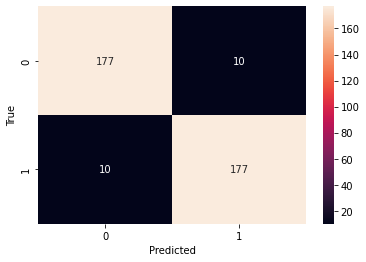

In [40]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm , annot = True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')

In [42]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       187
           1       0.95      0.95      0.95       187

    accuracy                           0.95       374
   macro avg       0.95      0.95      0.95       374
weighted avg       0.95      0.95      0.95       374



Inference

In [43]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

array([[0.7116952 ],
       [0.81463456],
       [0.7396539 ],
       [0.21000448],
       [0.13023014]], dtype=float32)